# Classfication Using Decision Tree, XGBoost and SVM on GPU Dataset

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [6]:
data= pd.read_csv("sgemm_product.csv")
data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [7]:
data.shape

(241600, 18)

In [8]:
data["Avg_Run"]=data[["Run1 (ms)","Run2 (ms)","Run3 (ms)","Run4 (ms)"]].mean(axis=1)
data=data.drop(columns=["Run1 (ms)","Run2 (ms)","Run3 (ms)","Run4 (ms)"],axis=1)
data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Avg_Run
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625


## Thresholding to convert it to classification 


In [9]:
data["Class"]= np.where(data["Avg_Run"]>np.median(data["Avg_Run"]),1,0)
data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Avg_Run,Class
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700,1
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050,1
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650,1
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375,1
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625,1


In [10]:
data["Class"].value_counts()

0    120801
1    120799
Name: Class, dtype: int64

# Data Partition

In [11]:
from sklearn.model_selection import train_test_split

def data_part(X, y, split_size) :
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = split_size)
    print(X_train.shape)
    print(X_test.shape)
    
    return X_train, X_test, y_train, y_test

In [12]:
X= data.drop(["Avg_Run","Class"],axis=1)
y=data["Class"]

In [13]:
X_train, X_test, y_train, y_test=data_part(X,y,split_size=0.2)

(193280, 14)
(48320, 14)


## Cross- Val to find out the Max-Depth

In [51]:
acc=[]
for i in range(2,30):
    DT = DecisionTreeClassifier(max_depth=i,random_state=42)
    scores_new = cross_val_score(DT, X_train, y_train, cv=5, scoring='accuracy')
    acc.append(scores_new.mean()) 

In [52]:
acc

[0.6974027317880795,
 0.7555256622516556,
 0.7868067052980132,
 0.8211868791390728,
 0.865702607615894,
 0.8900507036423841,
 0.9248913493377484,
 0.9376034768211919,
 0.9550600165562914,
 0.9665459437086092,
 0.9719112168874172,
 0.9790821605960266,
 0.9831487996688741,
 0.9862841473509933,
 0.9887106788079472,
 0.9891608029801324,
 0.9899679221854305,
 0.9900041390728476,
 0.9901748758278146,
 0.9900713990066226,
 0.9900351821192054,
 0.9900351821192054,
 0.9900351821192054,
 0.9900351821192054,
 0.9900351821192054,
 0.9900351821192054,
 0.9900351821192054,
 0.9900351821192054]

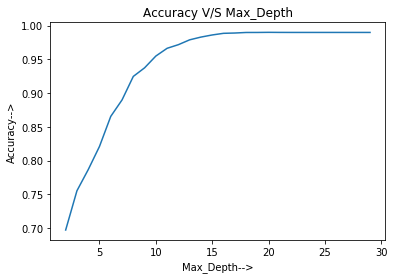

In [75]:
plt.plot(list(range(2,30)),acc)
plt.title("Accuracy V/S Max_Depth")
plt.xlabel("Max_Depth-->")
plt.ylabel("Accuracy-->")
plt.show()

## Decision Tree Classifier- Modeling

In [54]:
dec=DecisionTreeClassifier(max_depth=11,random_state=42)
dec.fit(X_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [55]:
scores= cross_val_score(dec, X_train, y_train, cv=10, scoring='accuracy')

In [56]:
scores

array([0.96616483, 0.96466449, 0.96652698, 0.96435408, 0.96694087,
       0.96621307, 0.9686449 , 0.96921405, 0.96859316, 0.96657526])

In [61]:
pred_test_dec=dec.predict(X_test)
pred_train_dec=dec.predict(X_train)

In [68]:
print("Training Accuracy:",accuracy_score(y_train,pred_train_dec))

Training Accuracy: 0.9677411009933775


In [69]:
print("Test Accuracy:",accuracy_score(y_test,pred_test_dec))

Test Accuracy: 0.9653973509933775


## Confusion Matrix

In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred_test_dec,labels=[0,1])

array([[23670,   546],
       [ 1126, 22978]], dtype=int64)

## ROC-AUC Curve

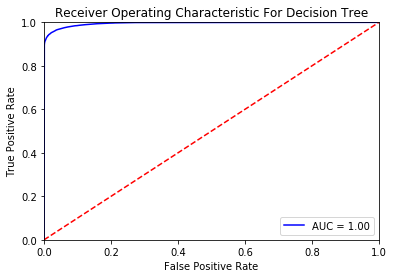

In [71]:
import sklearn.metrics as metrics
probs_dec = dec.predict_proba(X_test)
preds_dec = probs_dec[:,1]
fpr_dec, tpr_dec, threshold_dec = metrics.roc_curve(y_test, preds_dec)
roc_auc_dec = metrics.auc(fpr_dec, tpr_dec)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic For Decision Tree')
plt.plot(fpr_dec, tpr_dec, 'b', label = 'AUC = %0.2f' % roc_auc_dec)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Tree Construction

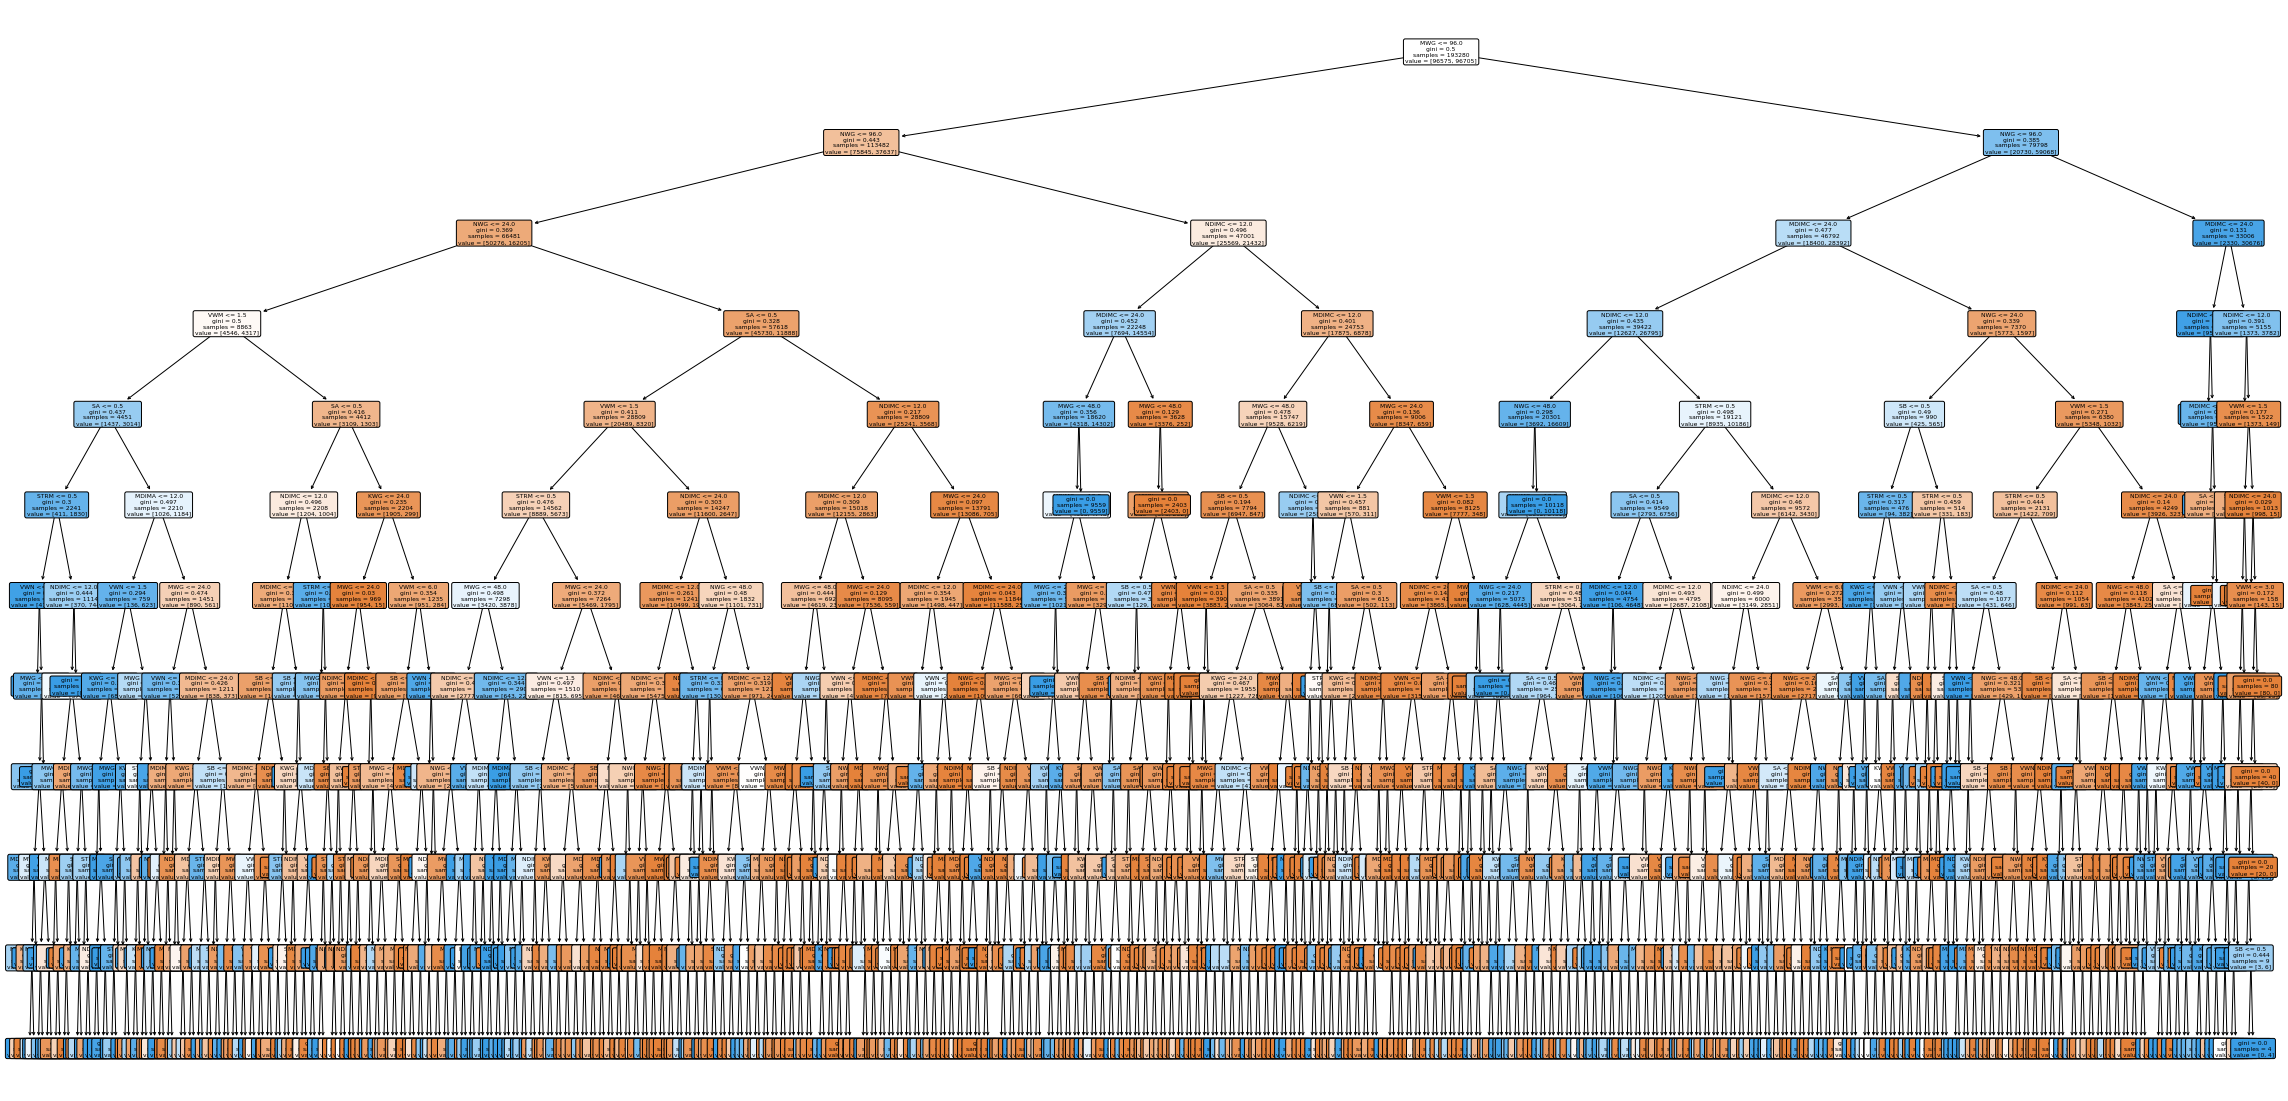

In [63]:
from sklearn import tree
plt.figure(figsize=(40,20))  
_ = tree.plot_tree(dec, feature_names = labels,class_names= ["0","1"],
             filled=True, fontsize=6, rounded = True)
plt.show()

# Function for GRIDSEARCHCV and MODEL EVAL

In [11]:
from sklearn.model_selection import GridSearchCV

def model_building(X, y, test, model, params = None, k = 1) :
    
    if params == None :
        
        ## Fit model 
        model.fit(X, y)
        
        # return fitted model & train-test predictions
        return (model, model.predict(X), model.predict(test))
    
    else :
        
        model_cv = GridSearchCV(model, param_grid = params, cv = k)
        
        ## Fit model_cv using 
        model_cv.fit(X, y)
        
        ## check best estimator 
        model = model_cv.best_estimator_
        
        print(model_cv.best_estimator_)
        # return and extra object for all cross validation operations
        return (model_cv, model, model.predict(X), model.predict(test))

In [12]:
from sklearn.metrics import accuracy_score
def model_evaluation(y_train, pred_train, y_test, pred_test) :
    
    print('''
            =========================================
               Accuracy FOR TRAIN DATA
            =========================================''')
    print("Accuracy : ", accuracy_score(y_train, pred_train))
    
    print('''
            =========================================
               Accuracy FOR TEST DATA
            =========================================''')
    print("Accuracy : ", accuracy_score(y_test, pred_test))

In [14]:
from xgboost import XGBClassifier
estimator= XGBClassifier(random_state=42)
parameters={'colsample_bytree': [0.55,0.7],'n_estimators':[200],'max_depth':[3,5,6,7],'learning_rate':[0.01,0.015]}

# XGBClassifier Modeling

In [15]:
model_cv, model, pred_train, pred_test = model_building(X_train, y_train,X_test, estimator, parameters, 5)
print('===================================================================\n\t\t\t',
          type(estimator).__name__,
          '\n===================================================================\n')
    
print(model_cv.best_params_, '\n\n')

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.015, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
			 XGBClassifier 

{'colsample_bytree': 0.7, 'learning_rate': 0.015, 'max_depth': 7, 'n_estimators': 200} 




In [16]:
model_evaluation(y_train, pred_train, y_test, pred_test)


               Accuracy FOR TRAIN DATA
Accuracy :  0.9549410182119206

               Accuracy FOR TEST DATA
Accuracy :  0.9536630794701987


In [17]:
accuracy_boost=[]
for i in range(2,9):
    Boost = XGBClassifier(max_depth=i,random_state=42,n_estimators=200,colsample_bytree=0.7,learning_rate=0.015)
    scores_boost = cross_val_score(Boost, X_train, y_train, cv=5, scoring='accuracy')
    accuracy_boost.append(scores_boost.mean())

In [18]:
accuracy_boost

[0.7984789126243739,
 0.8502949046170446,
 0.889341886182919,
 0.9183205739808041,
 0.9399161805465747,
 0.954170107182085,
 0.9620240024633411]

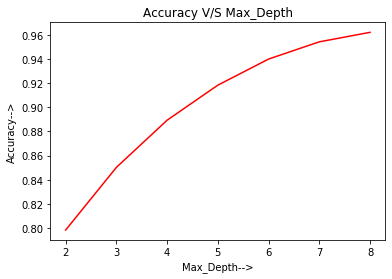

In [20]:
plt.plot(list(range(2,9)),accuracy_boost,color="red")
plt.title("Accuracy V/S Max_Depth")
plt.xlabel("Max_Depth-->")
plt.ylabel("Accuracy-->")
plt.show()

In [21]:
xgb=XGBClassifier(max_depth=8,random_state=42,n_estimators=200,colsample_bytree=0.7,learning_rate=0.015)
xgb.fit(X_train,y_train)
pred_train= xgb.predict(X_train)
pred_test=xgb.predict(X_test)


In [22]:
print("Final Training Accuracy:",accuracy_score(y_train,pred_train))
print("Final Testing Accuracy:",accuracy_score(y_test,pred_test))

Final Training Accuracy: 0.9631984685430464
Final Testing Accuracy: 0.9617549668874172


## Confusion-Matrix

In [23]:
confusion_matrix(y_test,pred_test,labels=[0,1])

array([[23701,   326],
       [ 1522, 22771]], dtype=int64)

In [24]:
True_Negative, False_Positive, False_Negative, True_Positive =confusion_matrix(y_test,pred_test).ravel()

In [25]:
True_Negative, False_Positive, False_Negative, True_Positive

(23701, 326, 1522, 22771)

## ROC_AUC CURVE

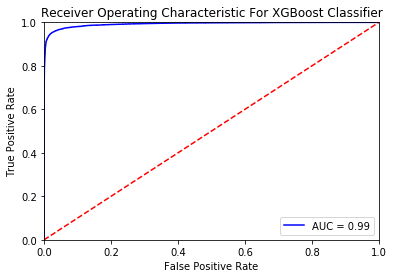

In [26]:
import sklearn.metrics as metrics
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic For XGBoost Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:
data_sample= data.sample(n=15000,random_state=42)

In [15]:
X_S= data_sample.drop(["Avg_Run","Class"],axis=1)
y_S=data_sample["Class"]

In [16]:
X_train_S, X_test_S, y_train_S, y_test_S=data_part(X_S,y_S,split_size=0.25)

(11250, 14)
(3750, 14)


## SVM Modeling - Finding Best Kernel Method according to Accuracy Score

In [16]:
kernels=["linear","rbf","sigmoid"]
accuracy_svc=[]
for i in kernels:
    svc=SVC(random_state=42,kernel=i)
    svc.fit(X_train_S,y_train_S)
    pred_S=svc.predict(X_test_S)
    accuracy_test=accuracy_score(y_test_S,pred_S)
    accuracy_svc.append(accuracy_test)

C:\Users\nishc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nishc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [18]:
accuracy_svc

[0.8336, 0.876, 0.4978666666666667]

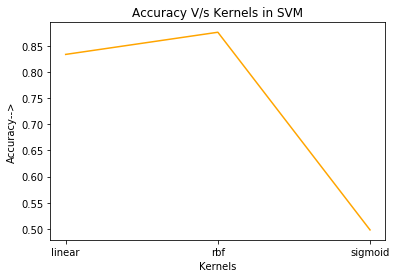

In [17]:
plt.plot(kernels,accuracy_svc,color="orange")
plt.title("Accuracy V/s Kernels in SVM")
plt.xlabel("Kernels")
plt.ylabel("Accuracy-->")
plt.show()


In [17]:
svc_rbf=SVC(random_state=42,kernel="rbf")
svc_rbf.fit(X_train_S,y_train_S)
pred_y_s=svc_rbf.predict(X_test_S)

C:\Users\nishc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Confusion-Matrix

In [18]:
confusion_matrix(y_test_S,pred_y_s,labels=[0,1])

array([[1688,  173],
       [ 324, 1565]], dtype=int64)